# TopoDiff sample

#### This notebook aims to launch a generation of topologies by TopoDiff, with a set of constraints given as input. Three trained models are needed to sample from TopoDiff: the main diffusion model, the classifier and the regressor. To load the trained models, you must specify the location of the checkpoints (either downloaded or gotten from your own trainings).

In [ ]:
import torch as th
import numpy as np
import matplotlib.pyplot as plt
import os
import pytorch_fid
import cv2
import sys

🚀 훈련 로그 분석 시작...
📊 발견된 메트릭들: ['cond_vf_mean', 'cond_ym_mean', 'grad_norm', 'lg_loss_scale', 'loss', 'loss_q0', 'loss_q1', 'loss_q2', 'mse', 'mse_q0', 'mse_q1', 'mse_q2', 'param_norm', 'samples', 'vb', 'vb_q0', 'vb_q1', 'vb_q2']
📈 총 30 스텝의 데이터


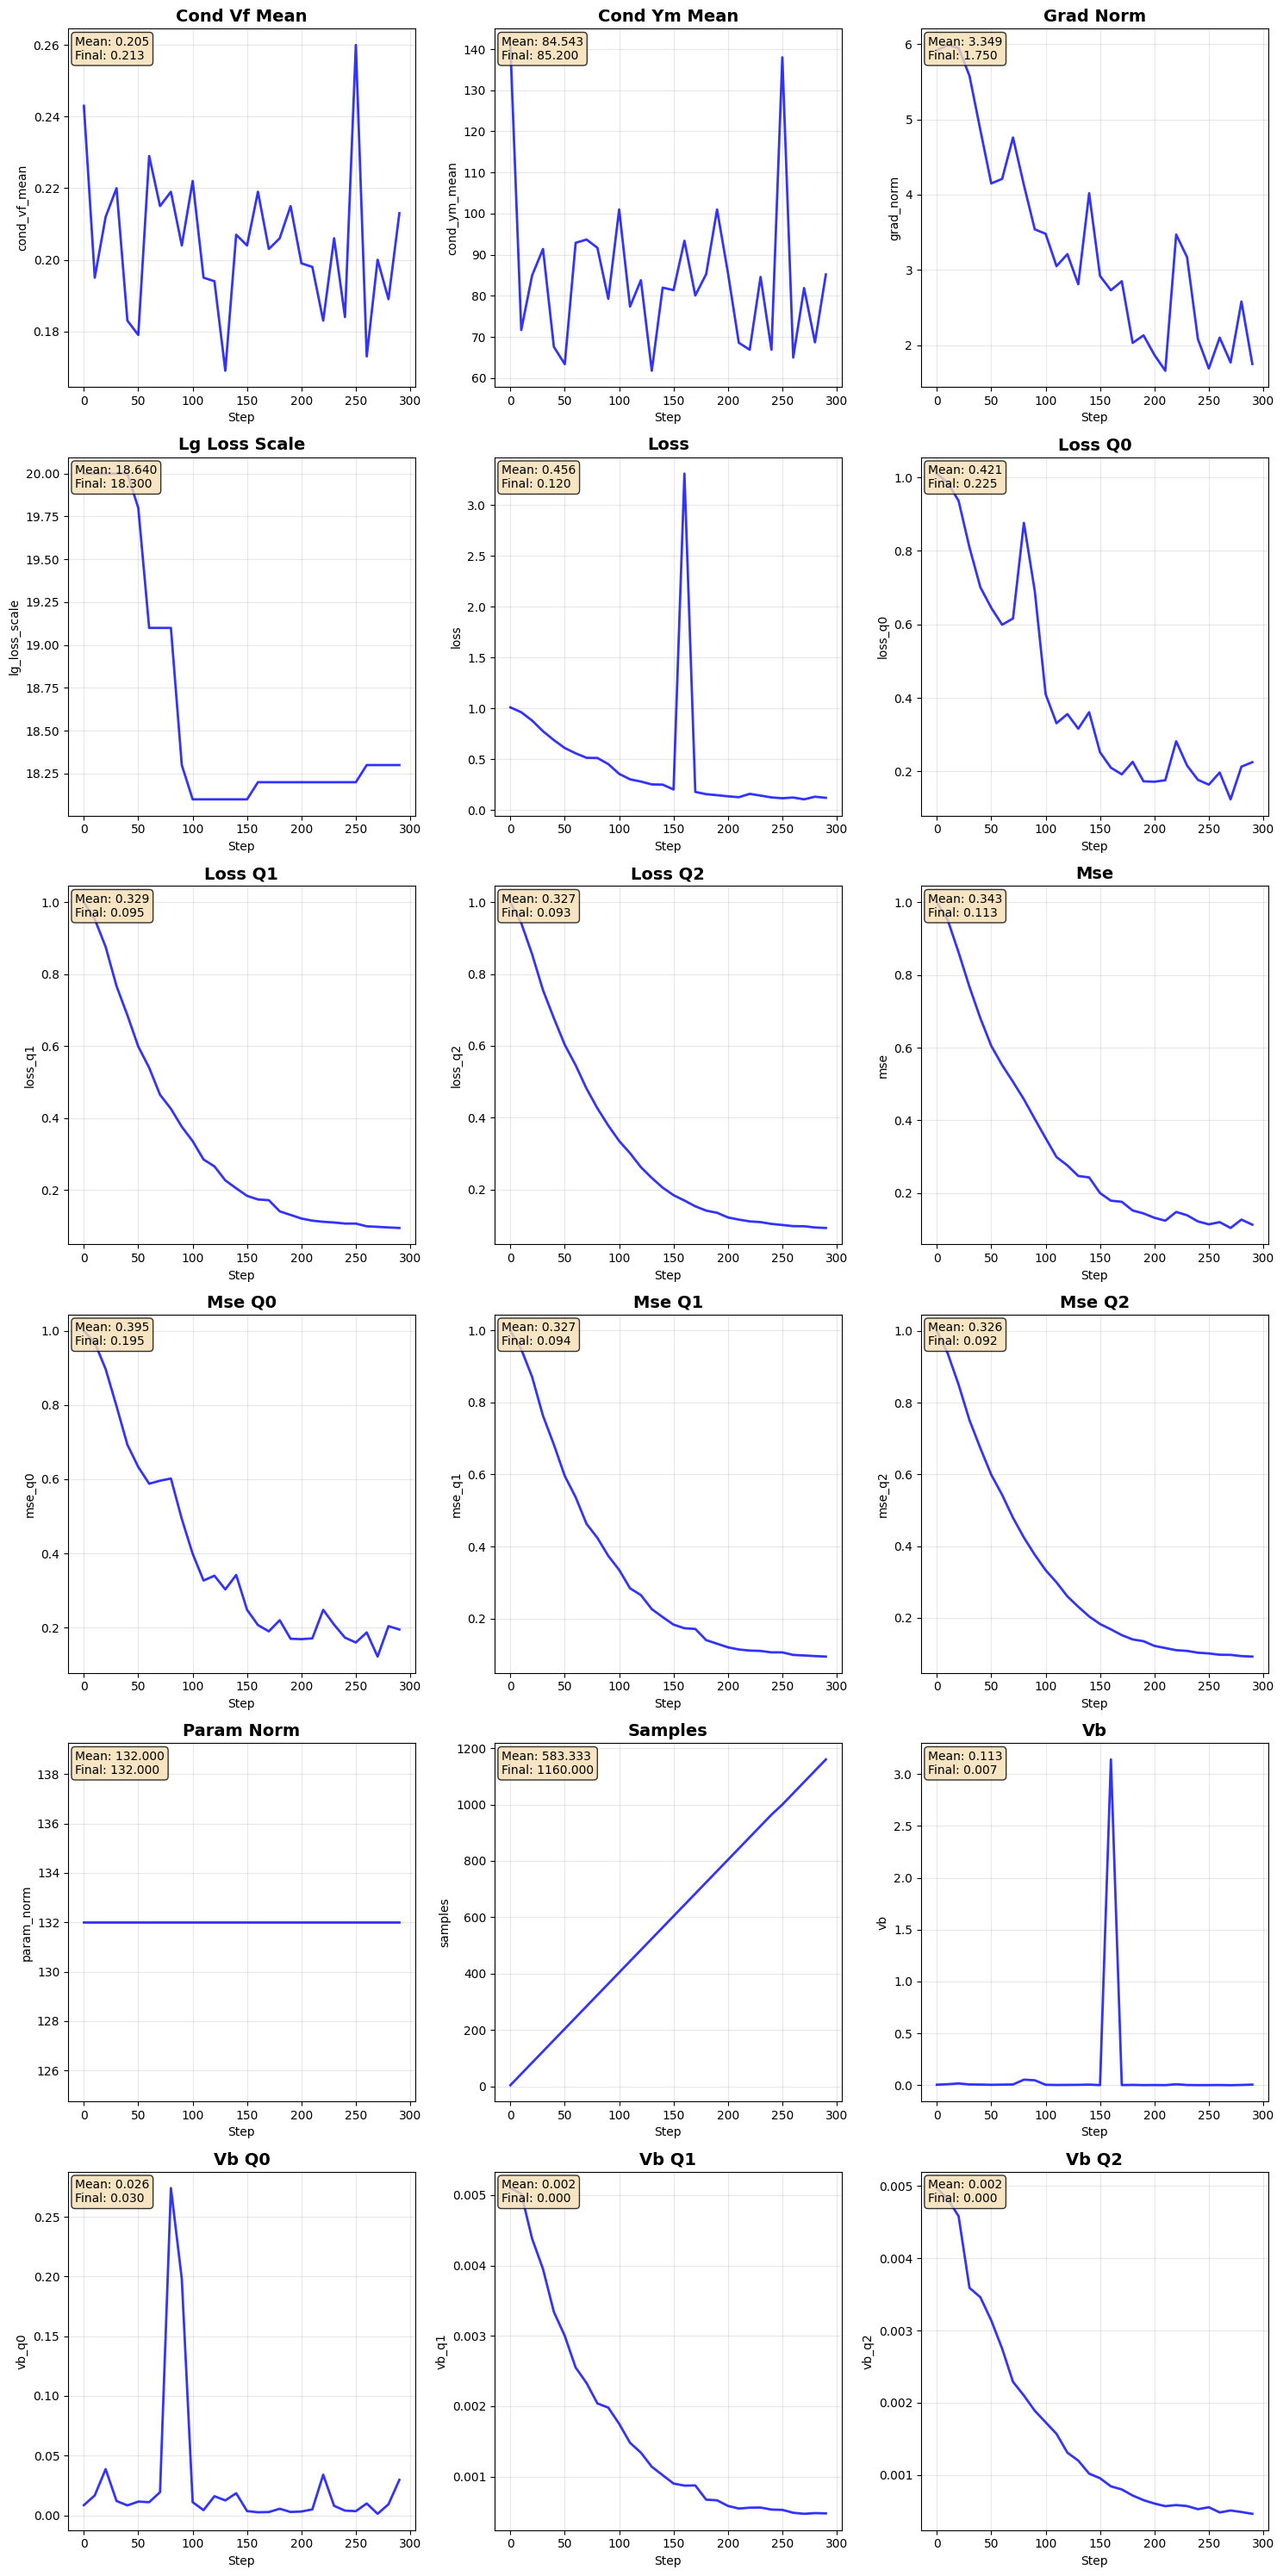


📋 훈련 요약:
----------------------------------------
cond_vf_mean:   0.2430 →   0.2130 ( -12.3%)
cond_ym_mean: 141.0000 →  85.2000 ( -39.6%)
grad_norm   :   5.9200 →   1.7500 ( -70.4%)
lg_loss_scale:  20.0000 →  18.3000 (  -8.5%)
loss        :   1.0100 →   0.1200 ( -88.1%)
loss_q0     :   1.0100 →   0.2250 ( -77.7%)
loss_q1     :   1.0000 →   0.0948 ( -90.5%)
loss_q2     :   1.0000 →   0.0927 ( -90.7%)
mse         :   1.0000 →   0.1130 ( -88.7%)
mse_q0      :   1.0000 →   0.1950 ( -80.5%)
mse_q1      :   0.9990 →   0.0943 ( -90.6%)
mse_q2      :   1.0000 →   0.0922 ( -90.8%)
param_norm  : 132.0000 → 132.0000 (  +0.0%)
samples     :   4.0000 → 1160.0000 (+28900.0%)
vb          :   0.0059 →   0.0066 ( +12.9%)
vb_q0       :   0.0085 →   0.0297 (+248.2%)
vb_q1       :   0.0051 →   0.0005 ( -90.6%)
vb_q2       :   0.0050 →   0.0005 ( -90.7%)

🔍 학습 상태 분석:
- 총 스텝: 31
- 초기 손실: 1.0100
- 현재 손실: 0.1130
- 최근 10스텝 트렌드: ⬇️ 감소 (-0.003000/step)
✅ 모델이 수렴하고 있습니다!


In [9]:
import matplotlib.pyplot as plt
import re
import numpy as np
from collections import defaultdict

def parse_log_file(log_path):
    """로그 파일을 파싱해서 메트릭들을 추출"""
    metrics = defaultdict(list)
    
    with open(log_path, 'r') as f:
        content = f.read()
    
    # 로그 블록들을 찾기 (| key | value | 형태)
    log_blocks = re.findall(r'(?:\| \w+.*?\|.*?\|\n)+', content)
    
    for block in log_blocks:
        step_data = {}
        lines = block.strip().split('\n')
        
        for line in lines:
            # | key | value | 형태 파싱
            match = re.match(r'\|\s*(\w+)\s*\|\s*([0-9\.e\-\+]+)\s*\|', line)
            if match:
                key, value = match.groups()
                try:
                    step_data[key] = float(value)
                except ValueError:
                    step_data[key] = value
        
        # step이 있으면 해당 블록의 데이터 저장
        if 'step' in step_data:
            for key, value in step_data.items():
                metrics[key].append(value)
    
    return dict(metrics)

def plot_training_metrics(log_path):
    """훈련 메트릭들을 그래프로 시각화"""
    metrics = parse_log_file(log_path)
    
    if not metrics or 'step' not in metrics:
        print("❌ 로그 파일에서 step 정보를 찾을 수 없습니다.")
        return
    
    steps = metrics['step']
    
    # 사용 가능한 메트릭들 확인
    available_metrics = [k for k in metrics.keys() if k != 'step' and len(metrics[k]) == len(steps)]
    
    print(f"📊 발견된 메트릭들: {available_metrics}")
    print(f"📈 총 {len(steps)} 스텝의 데이터")
    
    # 서브플롯 개수 결정
    n_metrics = len(available_metrics)
    if n_metrics == 0:
        print("❌ 플롯할 메트릭이 없습니다.")
        return
    
    # 그리드 크기 계산
    n_cols = min(3, n_metrics)
    n_rows = (n_metrics + n_cols - 1) // n_cols
    
    plt.figure(figsize=(15, 5*n_rows))
    
    for i, metric in enumerate(available_metrics, 1):
        plt.subplot(n_rows, n_cols, i)
        values = metrics[metric]
        
        plt.plot(steps, values, 'b-', linewidth=2, alpha=0.8)
        plt.title(f'{metric.replace("_", " ").title()}', fontsize=14, fontweight='bold')
        plt.xlabel('Step')
        plt.ylabel(metric)
        plt.grid(True, alpha=0.3)
        
        # Y축 스케일 조정
        if metric in ['loss', 'vb'] and max(values) > 10:
            plt.yscale('log')
            plt.ylabel(f'{metric} (log scale)')
        
        # 통계 정보 표시
        mean_val = np.mean(values)
        final_val = values[-1] if values else 0
        plt.text(0.02, 0.98, f'Mean: {mean_val:.3f}\nFinal: {final_val:.3f}', 
                transform=plt.gca().transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 요약 통계
    print("\n📋 훈련 요약:")
    print("-" * 40)
    for metric in available_metrics:
        values = metrics[metric]
        if values:
            initial = values[0]
            final = values[-1]
            change = ((final - initial) / initial * 100) if initial != 0 else 0
            print(f"{metric:12}: {initial:8.4f} → {final:8.4f} ({change:+6.1f}%)")

def analyze_learning_progress(log_path):
    """학습 진행 상황 상세 분석"""
    metrics = parse_log_file(log_path)
    
    if 'loss' not in metrics or 'step' not in metrics:
        print("❌ loss 또는 step 정보가 없습니다.")
        return
    
    steps = np.array(metrics['step'])
    loss = np.array(metrics['loss'])
    
    # 학습 안정성 분석
    if len(loss) > 5:
        # 최근 손실의 변화율
        recent_steps = min(10, len(loss))
        recent_loss = loss[-recent_steps:]
        loss_trend = np.polyfit(range(recent_steps), recent_loss, 1)[0]
        
        print(f"\n🔍 학습 상태 분석:")
        print(f"- 총 스텝: {len(steps)}")
        print(f"- 초기 손실: {loss[0]:.4f}")
        print(f"- 현재 손실: {loss[-1]:.4f}")
        print(f"- 최근 {recent_steps}스텝 트렌드: {'⬇️ 감소' if loss_trend < 0 else '⬆️ 증가'} ({loss_trend:.6f}/step)")
        
        # 수렴 여부 판단
        if len(loss) > 20:
            recent_var = np.var(recent_loss)
            if recent_var < 0.1 and abs(loss_trend) < 0.01:
                print("✅ 모델이 수렴하고 있습니다!")
            elif loss_trend > 0.1:
                print("⚠️ 손실이 증가하고 있습니다. 학습률을 낮춰보세요.")
            else:
                print("🔄 모델이 계속 학습 중입니다.")

# 실행
if __name__ == "__main__":
    log_path = "/home/yeoneung/Euihyun/3D_TPMS_topoDIff/topodiff/checkpoints/3d_diff_logdir3/log.txt"
    
    print("🚀 훈련 로그 분석 시작...")
    plot_training_metrics(log_path)
    analyze_learning_progress(log_path)

In [2]:
import torch
from torch.utils.data import next
import numpy as np
from topodiff.image_datasets_diffusion_model import load_data

# 설정: 데이터 경로와 파라미터
data_dir = "/home/yeoneung/Euihyun/3D_TPMS_topoDIff/data"
batch_size = 2
image_size = 64

# 데이터 로더 준비
data_iter = load_data(data_dir=data_dir, batch_size=batch_size, image_size=image_size, deterministic=True)
volumes, dummy_cons, _ = next(data_iter)  # volumes: [B, 3, D, H, W]

# 각 채널별 통계 출력
for i in range(volumes.shape[1]):
    ch = volumes[0, i].numpy()
    print(f"Channel {i}:")
    print(f"  Shape: {ch.shape}")
    print(f"  Min: {ch.min():.4f}, Max: {ch.max():.4f}, Mean: {ch.mean():.4f}")
    # 상수 채널인지 확인
    if np.allclose(ch, ch.flat[0]):
        print(f"  -> Channel {i} is constant with value {ch.flat[0]:.4f}")
    print()


ImportError: cannot import name 'next' from 'torch.utils.data' (/home/yeoneung/miniconda3/envs/topodiff/lib/python3.8/site-packages/torch/utils/data/__init__.py)

In [ ]:
import matplotlib.pyplot as plt
import re
import numpy as np
from collections import defaultdict

def parse_log_file(log_path):
    """로그 파일을 파싱해서 메트릭들을 추출"""
    metrics = defaultdict(list)
    
    with open(log_path, 'r') as f:
        content = f.read()
    
    # 로그 블록들을 찾기 (| key | value | 형태)
    log_blocks = re.findall(r'(?:\| \w+.*?\|.*?\|\n)+', content)
    
    for block in log_blocks:
        step_data = {}
        lines = block.strip().split('\n')
        
        for line in lines:
            # | key | value | 형태 파싱
            match = re.match(r'\|\s*(\w+)\s*\|\s*([0-9\.e\-\+]+)\s*\|', line)
            if match:
                key, value = match.groups()
                try:
                    step_data[key] = float(value)
                except ValueError:
                    step_data[key] = value
        
        # step이 있으면 해당 블록의 데이터 저장
        if 'step' in step_data:
            for key, value in step_data.items():
                metrics[key].append(value)
    
    return dict(metrics)

def plot_training_metrics(log_path):
    """훈련 메트릭들을 그래프로 시각화"""
    metrics = parse_log_file(log_path)
    
    if not metrics or 'step' not in metrics:
        print("❌ 로그 파일에서 step 정보를 찾을 수 없습니다.")
        return
    
    steps = metrics['step']
    
    # 사용 가능한 메트릭들 확인
    available_metrics = [k for k in metrics.keys() if k != 'step' and len(metrics[k]) == len(steps)]
    
    print(f"📊 발견된 메트릭들: {available_metrics}")
    print(f"📈 총 {len(steps)} 스텝의 데이터")
    
    # 서브플롯 개수 결정
    n_metrics = len(available_metrics)
    if n_metrics == 0:
        print("❌ 플롯할 메트릭이 없습니다.")
        return
    
    # 그리드 크기 계산
    n_cols = min(3, n_metrics)
    n_rows = (n_metrics + n_cols - 1) // n_cols
    
    plt.figure(figsize=(15, 5*n_rows))
    
    for i, metric in enumerate(available_metrics, 1):
        plt.subplot(n_rows, n_cols, i)
        values = metrics[metric]
        
        plt.plot(steps, values, 'b-', linewidth=2, alpha=0.8)
        plt.title(f'{metric.replace("_", " ").title()}', fontsize=14, fontweight='bold')
        plt.xlabel('Step')
        plt.ylabel(metric)
        plt.grid(True, alpha=0.3)
        
        # Y축 스케일 조정
        if metric in ['loss', 'vb'] and max(values) > 10:
            plt.yscale('log')
            plt.ylabel(f'{metric} (log scale)')
        
        # 통계 정보 표시
        mean_val = np.mean(values)
        final_val = values[-1] if values else 0
        plt.text(0.02, 0.98, f'Mean: {mean_val:.3f}\nFinal: {final_val:.3f}', 
                transform=plt.gca().transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 요약 통계
    print("\n📋 훈련 요약:")
    print("-" * 40)
    for metric in available_metrics:
        values = metrics[metric]
        if values:
            initial = values[0]
            final = values[-1]
            change = ((final - initial) / initial * 100) if initial != 0 else 0
            print(f"{metric:12}: {initial:8.4f} → {final:8.4f} ({change:+6.1f}%)")

def analyze_learning_progress(log_path):
    """학습 진행 상황 상세 분석"""
    metrics = parse_log_file(log_path)
    
    if 'loss' not in metrics or 'step' not in metrics:
        print("❌ loss 또는 step 정보가 없습니다.")
        return
    
    steps = np.array(metrics['step'])
    loss = np.array(metrics['loss'])
    
    # 학습 안정성 분석
    if len(loss) > 5:
        # 최근 손실의 변화율
        recent_steps = min(10, len(loss))
        recent_loss = loss[-recent_steps:]
        loss_trend = np.polyfit(range(recent_steps), recent_loss, 1)[0]
        
        print(f"\n🔍 학습 상태 분석:")
        print(f"- 총 스텝: {len(steps)}")
        print(f"- 초기 손실: {loss[0]:.4f}")
        print(f"- 현재 손실: {loss[-1]:.4f}")
        print(f"- 최근 {recent_steps}스텝 트렌드: {'⬇️ 감소' if loss_trend < 0 else '⬆️ 증가'} ({loss_trend:.6f}/step)")
        
        # 수렴 여부 판단
        if len(loss) > 20:
            recent_var = np.var(recent_loss)
            if recent_var < 0.1 and abs(loss_trend) < 0.01:
                print("✅ 모델이 수렴하고 있습니다!")
            elif loss_trend > 0.1:
                print("⚠️ 손실이 증가하고 있습니다. 학습률을 낮춰보세요.")
            else:
                print("🔄 모델이 계속 학습 중입니다.")

# 실행
if __name__ == "__main__":
    log_path = "/home/yeoneung/Euihyun/3D_TPMS_topoDIff/topodiff/checkpoints/3d_regressor_logdir2/log.txt"
    
    print("🚀 훈련 로그 분석 시작...")
    plot_training_metrics(log_path)
    analyze_learning_progress(log_path)

In [ ]:
MODEL_FLAGS="--image_size 64 --num_channels 32 --num_res_blocks 2 --learn_sigma True --use_checkpoint True"
DIFFUSION_FLAGS="--diffusion_steps 1000 --timestep_respacing 100 --noise_schedule cosine"
SAMPLE_FLAGS="--batch_size 1 --num_samples 1 --use_fp16 True"
MODEL_PATH="--model_path ./checkpoints/3d_diff_logdir2/model001000.pt"
CUDA_VISIBLE_DEVICES=1
%run scripts/topodiff_sample.py $MODEL_FLAGS $DIFFUSION_FLAGS $SAMPLE_FLAGS $MODEL_PATH

In [ ]:
import os

# 샘플링 전에 실행
os.environ['TOPODIFF_LOGDIR'] = '/home/yeoneung/Euihyun/3D_TPMS_topoDIff/topodiff/generated/3d_samples'  # 원하는 경로

# 그 다음 샘플링 실행
MODEL_FLAGS="--image_size 64 --num_channels 32 --num_res_blocks 2 --learn_sigma True --use_checkpoint True --use_fp16 True"
DIFFUSION_FLAGS="--diffusion_steps 1000 --timestep_respacing 100 --noise_schedule cosine"
SAMPLE_FLAGS="--batch_size 1 --num_samples 1 --use_fp16 True"
MODEL_PATH="--model_path ./checkpoints/3d_diff_logdir/model000000.pt"

%run scripts/topodiff_sample.py $MODEL_FLAGS $DIFFUSION_FLAGS $SAMPLE_FLAGS $MODEL_PATH

In [ ]:
import os
import numpy as np

def merge_npz_meta(npz_path, meta_path, out_path):
    # 1) 구조 볼륨 로드
    data = np.load(npz_path)
    vol = data['arr_0'].astype(np.float32)  # (D,H,W)
    # 2) 메타 로드 (vf, ym)
    vf, ym = np.load(meta_path).astype(np.float32)
    # 3) VF/YM 맵 생성
    D, H, W = vol.shape
    vf_map = np.full((D, H, W), vf, dtype=np.float32)
    ym_map = np.full((D, H, W), ym, dtype=np.float32)
    # 4) 채널 결합
    merged = np.stack([vol, vf_map, ym_map], axis=-1)  # (D,H,W,3)
    # 5) 저장
    np.savez_compressed(out_path, arr_0=merged)

if __name__ == '__main__':
    data_dir = '/home/yeoneung/Euihyun/3D_TPMS_topoDIff/data'
    for fname in os.listdir(data_dir):
        if fname.endswith('_implicit.npz'):
            # '_implicit.npz' suffix를 정확히 제거하여 base 추출
            base = fname.replace('_implicit.npz', '')
            npz_p = os.path.join(data_dir, fname)
            meta_p = os.path.join(data_dir, base + '_meta.npy')
            out_p = os.path.join(data_dir, base + '_cond.npz')
            merge_npz_meta(npz_p, meta_p, out_p)

In [ ]:
import os
os.environ['TOPODIFF_LOGDIR'] = '/home/yeoneung/Euihyun/3D_TPMS_topoDIff/topodiff/generated/3d_samples2'  # 원하는 경로

MODEL_FLAGS="--image_size 64 --num_channels 32 --num_res_blocks 2 --learn_sigma True --use_checkpoint True"
DIFFUSION_FLAGS="--diffusion_steps 1000 --timestep_respacing 100 --noise_schedule cosine"
REGRESSOR_FLAGS="--regressor_width 64 --regressor_depth 3 --regressor_pool adaptive"
SAMPLE_FLAGS="--batch_size 1 --num_samples 1 --use_fp16 True --regressor_use_fp16 True"
PATHS="--model_path ./checkpoints/3d_diff_logdir2/model003000.pt --regressor_path ./checkpoints/3d_regressor_logdir2/regressor010000.pt"
TARGETS="--target_vf 0.35 --target_youngs 250.0 --regressor_scale 50.0 --use_guidance True"

%run scripts/topodiff_sample.py $MODEL_FLAGS $DIFFUSION_FLAGS $REGRESSOR_FLAGS $SAMPLE_FLAGS $PATHS $TARGETS

In [ ]:
# 생성된 샘플 로드하고 확인
import numpy as np
import matplotlib.pyplot as plt

# 샘플 로드
sample_path = "/home/yeoneung/Euihyun/3D_TPMS_topoDIff/topodiff/generated/3d_samples/sample_0000.npz"
data = np.load(sample_path)
volume = data['arr_0']

print(f"Shape: {volume.shape}")
print(f"Value range: [{volume.min():.3f}, {volume.max():.3f}]")
print(f"Mean: {volume.mean():.3f}, Std: {volume.std():.3f}")

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(volume[32, :, :], cmap='coolwarm')
axes[0].set_title('X=32')
axes[1].imshow(volume[:, 32, :], cmap='coolwarm')
axes[1].set_title('Y=32')
axes[2].imshow(volume[:, :, 32], cmap='coolwarm')
axes[2].set_title('Z=32')
plt.show()

In [ ]:
import numpy as np

# 파일 경로
file_path = "/home/yeoneung/Euihyun/3D_TPMS_topoDIff/data/material_prop/t0.2_dia0.1_fis0.1_iwp0.1_lid0.7_meta.npy"

# 파일 로드
data = np.load(file_path, allow_pickle=True)

# 기본 정보 출력
print("데이터 타입:", type(data))
print("데이터 shape:", getattr(data, 'shape', 'N/A'))

# 내용 미리 보기
print("내용 일부:")
print(data if isinstance(data, dict) else data[:10])


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 샘플 로드
sample_path = "/home/yeoneung/Euihyun/3D_TPMS_topoDIff/topodiff/generated/3d_samples2/sample_0000.npz"
data = np.load(sample_path)
volume = data['arr_0']

# 1. 기본 통계 정보
print("=== Basic Statistics ===")
print(f"Shape: {volume.shape}")
print(f"Data type: {volume.dtype}")
print(f"Total elements: {volume.size}")
print(f"Memory size: {volume.nbytes / 1024 / 1024:.2f} MB")
print()

print("=== Value Range ===")
print(f"Min value: {volume.min():.6f}")
print(f"Max value: {volume.max():.6f}")
print(f"Range: {volume.max() - volume.min():.6f}")
print()

print("=== Central Tendency ===")
print(f"Mean: {volume.mean():.6f}")
print(f"Median: {np.median(volume):.6f}")
print(f"Std deviation: {volume.std():.6f}")
print(f"Variance: {volume.var():.6f}")
print()

print("=== Percentiles ===")
percentiles = [0, 10, 25, 50, 75, 90, 100]
for p in percentiles:
    print(f"{p}th percentile: {np.percentile(volume, p):.6f}")
print()

# 2. NaN과 Inf 체크
print("=== Data Quality Check ===")
nan_count = np.isnan(volume).sum()
inf_count = np.isinf(volume).sum()
print(f"NaN values: {nan_count} ({nan_count/volume.size*100:.2f}%)")
print(f"Inf values: {inf_count} ({inf_count/volume.size*100:.2f}%)")
print(f"Finite values: {np.isfinite(volume).sum()} ({np.isfinite(volume).sum()/volume.size*100:.2f}%)")

# 유효한 값들만으로 통계 (NaN 제외)
if nan_count > 0:
    valid_volume = volume[np.isfinite(volume)]
    print("\n=== Statistics for Valid Values Only ===")
    print(f"Valid count: {len(valid_volume)}")
    print(f"Valid min: {valid_volume.min():.6f}")
    print(f"Valid max: {valid_volume.max():.6f}")
    print(f"Valid mean: {valid_volume.mean():.6f}")
    print(f"Valid std: {valid_volume.std():.6f}")

# 3. 값의 분포 시각화
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 히스토그램
ax1 = axes[0, 0]
valid_data = volume[np.isfinite(volume)].flatten()
if len(valid_data) > 0:
    ax1.hist(valid_data, bins=50, edgecolor='black', alpha=0.7)
    ax1.axvline(np.mean(valid_data), color='red', linestyle='--', label=f'Mean: {np.mean(valid_data):.3f}')
    ax1.axvline(np.median(valid_data), color='green', linestyle='--', label=f'Median: {np.median(valid_data):.3f}')
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Value Distribution')
    ax1.legend()
else:
    ax1.text(0.5, 0.5, 'No valid data', ha='center', va='center')
    ax1.set_title('Value Distribution (No valid data)')

# Box plot
ax2 = axes[0, 1]
if len(valid_data) > 0:
    ax2.boxplot(valid_data, vert=True)
    ax2.set_ylabel('Value')
    ax2.set_title('Box Plot')
else:
    ax2.text(0.5, 0.5, 'No valid data', ha='center', va='center')
    ax2.set_title('Box Plot (No valid data)')

# 각 차원별 평균값
ax3 = axes[1, 0]
if not np.all(np.isnan(volume)):
    mean_x = np.nanmean(volume, axis=(1, 2))
    mean_y = np.nanmean(volume, axis=(0, 2))
    mean_z = np.nanmean(volume, axis=(0, 1))
    
    ax3.plot(mean_x, label='Mean along X', alpha=0.7)
    ax3.plot(mean_y, label='Mean along Y', alpha=0.7)
    ax3.plot(mean_z, label='Mean along Z', alpha=0.7)
    ax3.set_xlabel('Position')
    ax3.set_ylabel('Mean Value')
    ax3.set_title('Mean Values Along Each Axis')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'All NaN values', ha='center', va='center')
    ax3.set_title('Mean Values (All NaN)')

# 3D scatter plot (샘플링된 점들만)
ax4 = axes[1, 1]
ax4.remove()  # 2D 축 제거
ax4 = fig.add_subplot(2, 2, 4, projection='3d')

if not np.all(np.isnan(volume)) and np.any(np.isfinite(volume)):
    # 유효한 값들 중 일부만 샘플링 (메모리 절약)
    valid_mask = np.isfinite(volume)
    valid_indices = np.where(valid_mask)
    
    # 랜덤 샘플링
    n_samples = min(5000, len(valid_indices[0]))
    sample_indices = np.random.choice(len(valid_indices[0]), n_samples, replace=False)
    
    x = valid_indices[0][sample_indices]
    y = valid_indices[1][sample_indices]
    z = valid_indices[2][sample_indices]
    values = volume[x, y, z]
    
    scatter = ax4.scatter(x, y, z, c=values, cmap='coolwarm', s=1, alpha=0.5)
    ax4.set_xlabel('X')
    ax4.set_ylabel('Y')
    ax4.set_zlabel('Z')
    ax4.set_title(f'3D Scatter (sampled {n_samples} points)')
    
    # 컬러바 추가
    plt.colorbar(scatter, ax=ax4, shrink=0.5)
else:
    ax4.text2D(0.5, 0.5, 'No valid data for 3D plot', transform=ax4.transAxes)

plt.tight_layout()
plt.show()

# 4. 슬라이스별 통계
print("\n=== Slice Statistics ===")
for dim, name in enumerate(['X', 'Y', 'Z']):
    if dim == 0:
        slice_means = [np.nanmean(volume[i, :, :]) for i in range(volume.shape[0])]
    elif dim == 1:
        slice_means = [np.nanmean(volume[:, i, :]) for i in range(volume.shape[1])]
    else:
        slice_means = [np.nanmean(volume[:, :, i]) for i in range(volume.shape[2])]
    
    slice_means = np.array(slice_means)
    valid_slices = slice_means[np.isfinite(slice_means)]
    
    if len(valid_slices) > 0:
        print(f"\n{name}-axis slices:")
        print(f"  Mean of slice means: {valid_slices.mean():.6f}")
        print(f"  Std of slice means: {valid_slices.std():.6f}")
        print(f"  Min slice mean: {valid_slices.min():.6f}")
        print(f"  Max slice mean: {valid_slices.max():.6f}")

In [ ]:
MODEL_FLAGS="--image_size 64 --num_channels 32 --num_res_blocks 1 --learn_sigma True --dropout 0.3 --attention_resolutions 128"
DIFFUSION_FLAGS="--diffusion_steps 1000 --timestep_respacing 50 --noise_schedule cosine"
SAMPLE_FLAGS="--num_samples 1 --batch_size 1 --clip_denoised True --vf 0.3 --youngs_modulus 2.0"
CHECKPOINT_FLAGS="--model_path ./checkpoints/diff_logdir/model010000.pt"

# 실행
%run scripts/topodiff_sample.py $MODEL_FLAGS $DIFFUSION_FLAGS $SAMPLE_FLAGS $CHECKPOINT_FLAGS


The environment variable 'TOPODIFF_LOGDIR' defines the directory where the logs and generated topologies will be saved.

In [ ]:
os.environ['TOPODIFF_LOGDIR'] = './generated'

The 'MODEL_FLAGS' and 'DIFFUSION_FLAGS' set the model and diffusion hyperparameters. They need to fit with the parameters that were used when training the corresponding models.

The default values indicated below correspond to the hyperparameters indicated in the Appendix to the paper.

In [ ]:
MODEL_FLAGS="--image_size 64 --num_channels 128 --num_res_blocks 3 --learn_sigma True --dropout 0.3 --use_fp16 True"
DIFFUSION_FLAGS="--diffusion_steps 1000 --timestep_respacing 100 --noise_schedule cosine"

The 'DATA_FLAGS' indicate the directory where the input constraints are. All inputs (physical fields, load arrays, boundary conditions arrays) need to be in the same directory (done by default in the data directory that we provide you with).

**You may change the 'DATA_FLAGS' to sample from the level 1 or level 2 test set.**

In [ ]:
DATA_FLAGS="--constraints_path ./data/dataset_1_diff/test_data_level_1 --num_samples 5"

The 'CHECKPOINTS_FLAGS' indicate where the checkpoints for the diffusion model, the regressor and the classifier are. **You need to indicate the directory where the trained models are.**

In [ ]:
CHECKPOINTS_FLAGS="--model_path ./checkpoints/TO_INDICATE --regressor_path ./checkpoints/TO_INDICATE --fm_classifier_path ./checkpoints/TO_INDICATE"

In [ ]:
%run scripts/topodiff_sample.py --regressor_scale 4.0 --classifier_fm_scale 3.0 $MODEL_FLAGS $DIFFUSION_FLAGS $DATA_FLAGS $CHECKPOINTS_FLAGS

*Note: TopoDiff generates the topologies in a different order than the file names. We therefore recommend you use the notebook 5_analysis.ipynb to conduct the analysis of the results.*